In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-01.csv
/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-03.csv
/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-02.csv
/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2015-01.csv


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NYCTaxiBigData").getOrCreate()

# Lire plusieurs fichiers d’un coup avec Spark
df = spark.read.csv([
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2015-01.csv",
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-01.csv",
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-02.csv",
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-03.csv"
], header=True, inferSchema=True)

df.printSchema()
df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/12 10:05:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+-----

In [3]:
# 1. Installation & setup Spark
!apt-get install -qq openjdk-8-jdk-headless
!wget -q https://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NYCTaxiBigData").getOrCreate()

df = spark.read.csv(
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_*.csv",
    header=True,
    inferSchema=True
)


# 4. Nettoyage des données
df = df.filter((df.trip_distance > 0) & (df.fare_amount > 0))

# 5. Transformations & agrégations
from pyspark.sql.functions import hour, avg, count

df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df.groupBy("pickup_hour").agg(
    count("*").alias("trips_count"),
    avg("trip_distance").alias("avg_distance"),
    avg("fare_amount").alias("avg_fare")
).orderBy("pickup_hour").show(24)

# 6. Sauvegarde optimisée
df.write.parquet("nyc_taxi_cleaned.parquet")


Selecting previously unselected package libxtst6:amd64.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk

+-----------+-----------+------------------+------------------+
|pickup_hour|trips_count|      avg_distance|          avg_fare|
+-----------+-----------+------------------+------------------+
|          0|    1378838| 3.957525329299027|14.753716448197695|
|          1|    1012530| 8.920055919330801| 14.37393016503216|
|          2|     746412| 3.858606506862158|14.219523185586521|
|          3|     560907| 4.123082400469233|14.829198262813621|
|          4|     423033| 4.894162937643153| 16.79495857297184|
|          5|     381619| 6.385962963060005|18.372745644215822|
|          6|     796736| 4.562933393244423|15.266456693308697|
|          7|    1338193|3.5061472149383572|13.849665444371631|
|          8|    1565729|3.6998037719171095|14.109377919167375|
|          9|    1553771|10.914554030162455|  14.1866844470646|
|         10|    1522968|17.824036329062352|14.297770189524671|
|         11|    1583929| 4.677033945334677|14.370430688496777|
|         12|    1670036|  3.38243664208

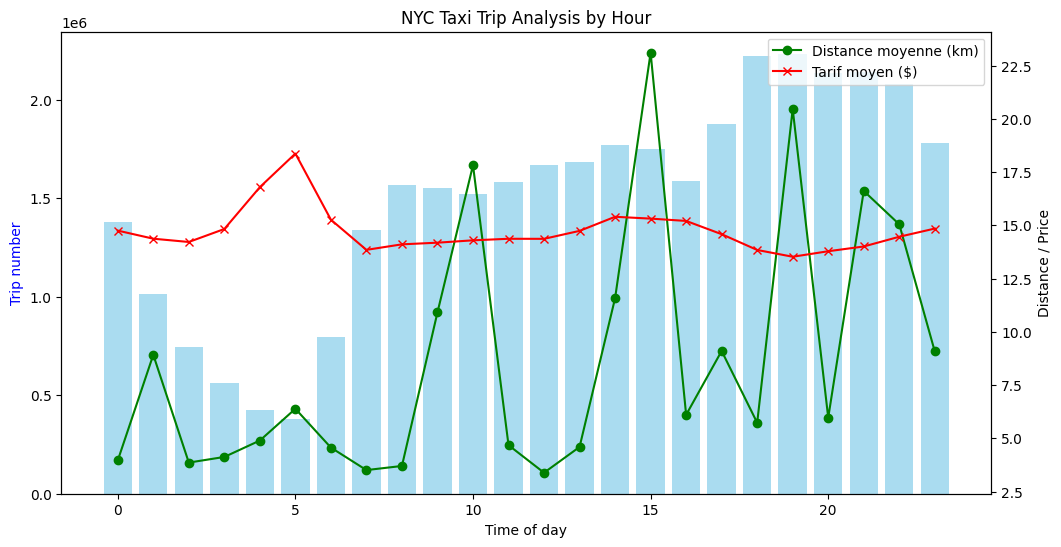

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Exemple : convert spark dataframe in pandas
pdf = df.groupBy("pickup_hour").agg(
    count("*").alias("trips_count"),
    avg("trip_distance").alias("avg_distance"),
    avg("fare_amount").alias("avg_fare")
).orderBy("pickup_hour").toPandas()

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pdf['pickup_hour'], pdf['trips_count'], color='skyblue', alpha=0.7)
ax1.set_ylabel('Trip number', color='blue')
ax1.set_xlabel('Time of day')

ax2 = ax1.twinx()
ax2.plot(pdf['pickup_hour'], pdf['avg_distance'], color='green', marker='o', label='Distance moyenne (km)')
ax2.plot(pdf['pickup_hour'], pdf['avg_fare'], color='red', marker='x', label='Tarif moyen ($)')
ax2.set_ylabel('Distance / Price')

ax2.legend(loc='upper right')
plt.title('NYC Taxi Trip Analysis by Hour')
plt.show()


In [5]:
df.groupBy("fare_amount").agg(count("*").alias("trips_count")) \
  .orderBy("trips_count", ascending=False).show(10)


+-----------+-----------+
|fare_amount|trips_count|
+-----------+-----------+
|        7.5|    1942499|
|          8|    1934955|
|          7|    1866453|
|        8.5|    1863517|
|          9|    1769334|
|        9.5|    1656516|
|        6.5|    1631672|
|         10|    1538467|
|       10.5|    1407642|
|         11|    1287846|
+-----------+-----------+
only showing top 10 rows



In [6]:
#corrélation distance/tarif
df.select("trip_distance", "fare_amount").describe().show()

from pyspark.sql.functions import corr

df.select(corr("trip_distance", "fare_amount")).show()


+-------+-----------------+------------------+
|summary|    trip_distance|       fare_amount|
+-------+-----------------+------------------+
|  count|         35800402|          35800402|
|   mean| 9.64141883965393|14.489307027055247|
| stddev|7377.350447939826| 51.18385237688636|
|    min|             1.00|                 1|
|    max|            99.90|            999.98|
+-------+-----------------+------------------+



+--------------------------------+
|corr(trip_distance, fare_amount)|
+--------------------------------+
|            0.010706540678233326|
+--------------------------------+



In [7]:

#anamaly detection: Trips with zero or very short distances but high fares,
#Trips with huge distances but very low fares,
#Negative or inconsistent travel times.
from sklearn.ensemble import IsolationForest
import pandas as pd

# sample pandas
sample_pdf = df.select("trip_distance", "fare_amount").sample(False, 0.01).toPandas()

clf = IsolationForest(contamination=0.01, random_state=42)
sample_pdf['anomaly'] = clf.fit_predict(sample_pdf[['trip_distance', 'fare_amount']])

# -1 = anomaly, 1 = normal
anomalies = sample_pdf[sample_pdf['anomaly'] == -1]
print(anomalies.head())


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


    trip_distance fare_amount  anomaly
14          21.10          52       -1
97          18.56          77       -1
226         21.40          52       -1
229         25.10         145       -1
414         23.30          66       -1
